## Panorama Stitching using SuperGlue
SuperGlue network is a Graph Neural Network combined with an Optimal Matching layer that is trained to perform matching on two sets of sparse image features.

**This project is heavily inspired by: [Stitch-images-using-SuperGlue-GNN](https://github.com/bimalka98/Stitch-images-using-SuperGlue-GNN.git)**

In [42]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [43]:
# generating the necessary txt file to input for the super glue algorithm
img_name = 'out' # set of outdoor images
num_images = 2
# Order of the images. To stitch left and right images as depicted in the below
order = range(num_images -1,0,-1) 
with open('pairs.txt', 'w') as file:
    for i in order:
        file.write("{img}-{:02}.jpg {img}-{:02}.jpg\n".format(i,i-1, img = img_name))

In [44]:
!python3.8 match_pairs.py  --input_dir imgs/ \
                         --superglue outdoor \
                        --input_pairs pairs.txt \
                        --output_dir panorama/output \
                        --resize_float \
                        --viz 

Namespace(cache=False, eval=False, fast_viz=False, force_cpu=False, input_dir='imgs/', input_pairs='pairs.txt', keypoint_threshold=0.005, match_threshold=0.2, max_keypoints=1024, max_length=-1, nms_radius=4, opencv_display=False, output_dir='panorama/output', resize=[640, 480], resize_float=True, show_keypoints=False, shuffle=False, sinkhorn_iterations=20, superglue='outdoor', viz=True, viz_extension='png')
Will resize to 640x480 (WxH)
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Looking for data in directory "imgs"
Will write matches to directory "panorama/output"
Will write visualization images to directory "panorama/output"
[Finished pair     0 of     1] load_image=0.017 matcher=2.660 viz_match=0.651 total=3.328 sec {0.3 FPS} 


In [45]:
#generatig the npz files for extract matching information
npz_files = ["{img}-{:02}_{img}-{:02}_matches.npz".format(i,i-1, img = img_name) for i in order]
for file in npz_files:
    path = 'panorama/output/'+file
    npz = np.load(path)
print(npz.files)

['keypoints0', 'keypoints1', 'matches', 'match_confidence']


For each keypoint in `keypoints0`, the `matches` array indicates the index of the matching keypoint in `keypoints1`, or `-1` if the keypoint is unmatched.

In [46]:
# extracting information from the npz files 
def loadNPZ(npz_file):    
    npz = np.load('panorama/output/'+ npz_file)
    point_set1 = npz['keypoints0'][npz['matches']>-1]
    matching_indexes =  npz['matches'][npz['matches']>-1] # -1 if the keypoint is unmatched
    point_set2 = npz['keypoints1'][matching_indexes]
    return point_set1, point_set2

In [47]:
def pltSourceImages(imageSet, point_set1, point_set2):    
    im_left = cv.imread('imgs/{img}-{:02}.jpg'.format(imageSet, img=img_name),cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('imgs/{img}-{:02}.jpg'.format(imageSet -1, img=img_name),cv.IMREAD_ANYCOLOR)
    im_left = cv.cvtColor(im_left, cv.COLOR_BGR2RGB)
    im_right = cv.cvtColor(im_right, cv.COLOR_BGR2RGB)
    if im_left is None or im_right is None:
        print('Could not open or find the images!')
    desired_width = 640
    desired_height = 480
    im_left = cv.resize(im_left, (desired_width, desired_height))
    im_right = cv.resize(im_right, (desired_width, desired_height))
    
    # Marking the detected features on the two images.
    for point in point_set1.astype(np.int32):
        cv.circle(im_left, tuple(point), radius=4, color=(255, 255, 0), thickness=-1)

    for point in point_set2.astype(np.int32):
        cv.circle(im_right, tuple(point), radius=4, color=(255, 255, 0), thickness=-1)

    fig = plt.figure(figsize = (10,10))
    plt.subplot(121),plt.imshow(im_left)
    plt.subplot(122),plt.imshow(im_right)
    plt.show()

In [48]:
def plotMatches(imageSet):
    plt.figure(figsize=(10,10))
    matched_points = cv.imread('panorama/output/{img}-{:02}_{img}-{:02}_matches.png'.format(imageSet, imageSet -1, img=img_name),cv.IMREAD_ANYCOLOR)
    if matched_points is None:
        print('Could not open or find the images!')
    plt.imshow(matched_points, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

In [49]:
def getDistanceMask(img, left_image = True):
    # Create a binary image with edges at the region where we want to start the gradient
    binary_image = np.ones((img.shape[0], img.shape[1]), dtype=np.uint8)
    binary_image[:, -1] = 0  # Right edge
    binary_image[:, 0] = 0 # left edge
    binary_image[-1, :] = 0  # Bottom edge
    binary_image[0, :] = 0  # Top edge
    # Compute distance nearest zero pixel (edge) for each pixel 
    distance_mask = cv.distanceTransform(binary_image, cv.DIST_L2, 3)
    # normalize
    normalized_mask = cv.normalize(distance_mask, distance_mask, 0, 1.0, cv.NORM_MINMAX)
    
    if len(img.shape) == 3 and img.shape[2] == 3:  # If the image is color
        normalized_mask = cv.merge([normalized_mask, normalized_mask, normalized_mask])
    return normalized_mask

Get result from OpenCV Stitching module to compare

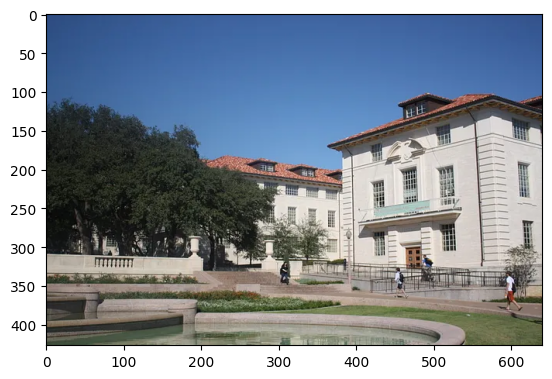

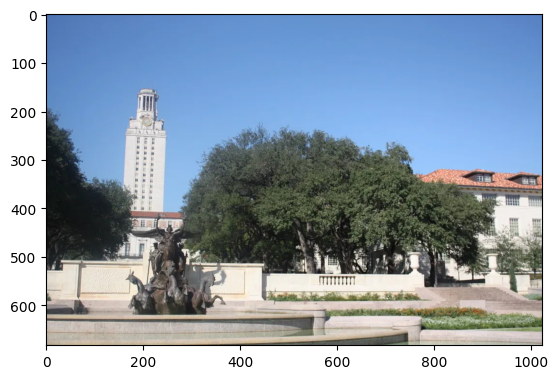

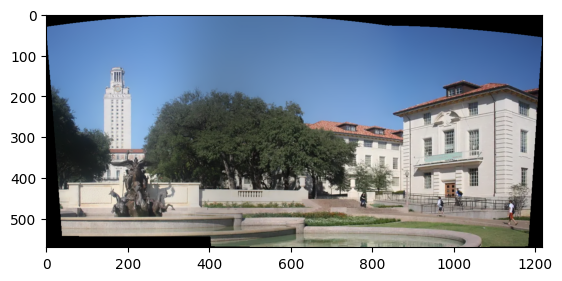

In [50]:
im_left = cv.imread(f'imgs/{img_name}-00.jpg',cv.IMREAD_ANYCOLOR)
im_right = cv.imread(f'imgs/{img_name}-01.jpg',cv.IMREAD_ANYCOLOR)    
im_left = cv.cvtColor(im_left, cv.COLOR_BGR2RGB)
im_right = cv.cvtColor(im_right, cv.COLOR_BGR2RGB)


stitcher = cv.Stitcher.create(cv.Stitcher_PANORAMA)
status, stitched = stitcher.stitch([im_left, im_right])



plt.imshow(im_left, cmap='gray', vmin = 0, vmax = 255)
plt.show()
plt.imshow(im_right, cmap='gray', vmin = 0, vmax = 255)
plt.show()
if status == cv.Stitcher_OK:
    plt.imshow(stitched, cmap='gray', vmin = 0, vmax = 255)
    plt.show()
else:
     print("Can't stitch images, error code = %d" % status)

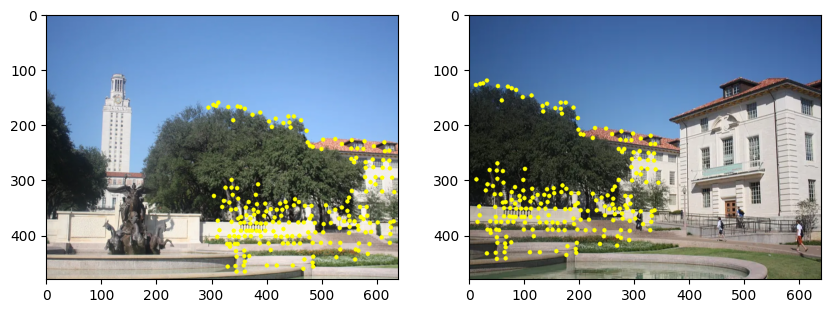

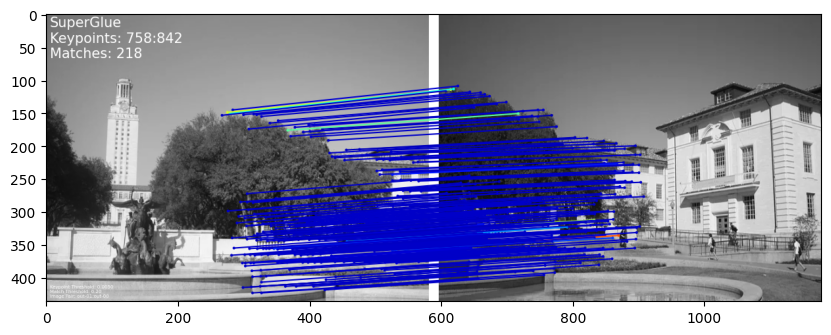

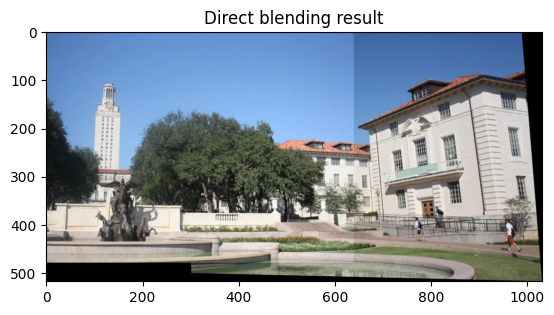

In [51]:

for imgSet in range(num_images-1,0,-1):  
    # loading points
    point_set1, point_set2 = loadNPZ(npz_files[num_images-1 -imgSet])
    pltSourceImages(imgSet, point_set1, point_set2)
    plotMatches(imgSet)    
    # getting the required source images
    im_left = cv.imread('imgs/{img}-{:02}.jpg'.format(imgSet, img=img_name))
    im_right = cv.imread('imgs/{img}-{:02}.jpg'.format(imgSet -1, img=img_name))
    im_left = cv.cvtColor(im_left, cv.COLOR_BGR2RGB)
    im_right = cv.cvtColor(im_right, cv.COLOR_BGR2RGB)
    
    # resize images to size same as the output of the superglue algorithm
    desired_width = 640 
    desired_height = 480
    im_left = cv.resize(im_left, (desired_width, desired_height))
    im_right = cv.resize(im_right, (desired_width, desired_height))
    

    homography, _ = cv.findHomography(point_set1, point_set2, cv.RANSAC, 5.0)

    # Warp the first image using the homography
    panorama = cv.warpPerspective(im_right, np.linalg.inv(homography), (640*2,480*2)) 
    
    im_left_gray = cv.cvtColor(im_left, cv.COLOR_BGR2GRAY)
    
    normalized_weights_left = getDistanceMask(im_left_gray)
    
    panorama[0:im_left.shape[0], 0:im_left.shape[1]] = im_left

    # crop black borders
    non_black_pixels = np.where(panorama.max(axis=2) > 0)
    min_x, max_x = non_black_pixels[1].min(), non_black_pixels[1].max()
    min_y, max_y = non_black_pixels[0].min(), non_black_pixels[0].max()
    panorama_cropped = panorama[min_y:max_y, min_x:max_x]
   
   
    plt.title('Direct blending result')
    plt.imshow(panorama_cropped, cmap='gray', vmin = 0, vmax = 255)
    plt.show()    
    panorama_cropped[0:im_left.shape[0], 0:im_left.shape[1]] = 0 # remove the left image from the panorama
    cv.imwrite("right.jpg", panorama_cropped)

In [ ]:
def create_gaussian_pyramid(image, levels):
    gaussian_pyramid = [image]
    for _ in range(1, levels):
        image = cv.pyrDown(image)
        gaussian_pyramid.append(image)
    return gaussian_pyramid

def create_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = [gaussian_pyramid[-1]]
    for i in range(len(gaussian_pyramid) - 1, 0, -1):
        size = (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0])
        gaussian_expanded = cv.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = cv.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid

def blend_pyramids(laplacian_a, laplacian_b, mask_pyramid):
    blended_pyramid = []
    for la, lb, mask in zip(laplacian_a, laplacian_b, mask_pyramid):
        blended = la * mask + lb * (1 - mask)
        #blended = np.hstack((la[:,0:la.shape[1]//2], lb[:,la.shape[1]//2:]))
        blended_pyramid.append(blended)
    return blended_pyramid

def reconstruct_from_pyramid(laplacian_pyramid):
    image = laplacian_pyramid[0]
    for i in range(1, len(laplacian_pyramid)):
        size = (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0])
        image = cv.pyrUp(image, dstsize=size)
        image = cv.add(image, laplacian_pyramid[i])
    return image

def create_mask(image):
    # Assuming that the black area corresponds to zero pixels
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, mask = cv.threshold(gray_image, 1, 255, cv.THRESH_BINARY)
    return mask

Test Orange and Apple blending

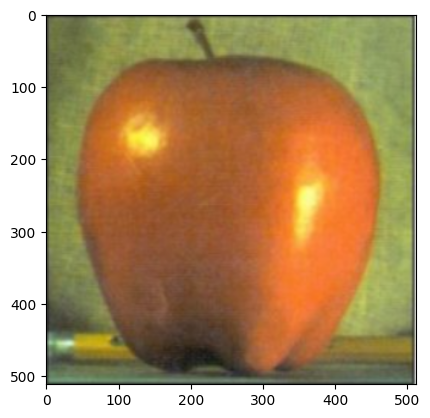

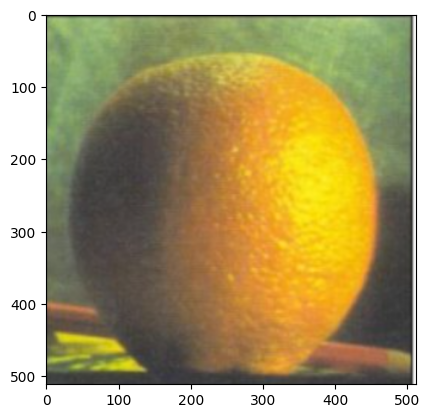

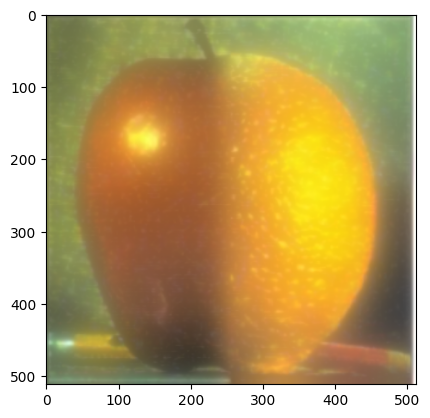

In [62]:
A = cv.imread('apple.png')
B = cv.imread('orange.png')

# resize to the same size 512 for simplicity
A = cv.resize(A, (512, 512))
B = cv.resize(B, (512, 512))

plt.imshow(cv.cvtColor(A, cv.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv.cvtColor(B, cv.COLOR_BGR2RGB))
plt.show()

levels = 6

gaussian_pyramid_a = create_gaussian_pyramid(A, levels)
laplacian_pyramid_a = create_laplacian_pyramid(gaussian_pyramid_a)

gaussian_pyramid_b = create_gaussian_pyramid(B, levels)
laplacian_pyramid_b = create_laplacian_pyramid(gaussian_pyramid_b)

# Create Gaussian pyramid for the mask 
# take half of each image
mask = np.zeros_like(A)
mask[:, 0:A.shape[1] // 2] = 1 

gaussian_pyramid_mask = create_gaussian_pyramid(mask, levels)

# reverse mask lsit (biggest is at the end as laplacian pyramid)
gaussian_pyramid_mask = gaussian_pyramid_mask[::-1]

blended_pyramid = blend_pyramids(laplacian_pyramid_a, laplacian_pyramid_b, gaussian_pyramid_mask)

result = reconstruct_from_pyramid(blended_pyramid)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()	


Blend panorama

(518, 640, 3) (518, 1031, 3)
(518, 1031, 3) (518, 1031, 3)


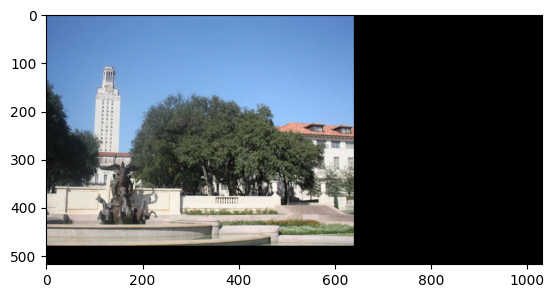

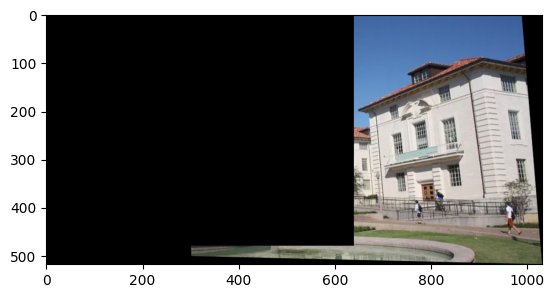

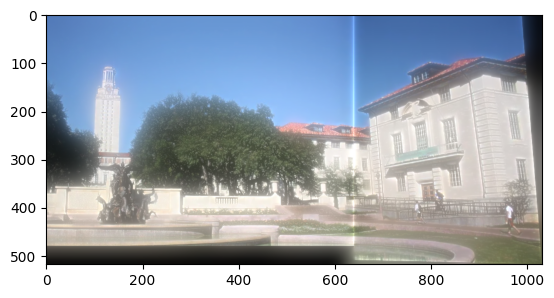

In [58]:

# Read images
A = cv.imread('im_left.jpg')
B = cv.imread('right.jpg')
A_shape = A.shape

# if one image is smaller, fill it with zeros
if A.shape[0] < B.shape[0]:
    A = np.concatenate((A, np.zeros((B.shape[0] - A.shape[0], A.shape[1], 3), dtype=np.uint8)), axis=0)
elif A.shape[0] > B.shape[0]:
    B = np.concatenate((B, np.zeros((A.shape[0] - B.shape[0], B.shape[1], 3), dtype=np.uint8)), axis=0)
print(A.shape, B.shape)

# also with width
if A.shape[1] < B.shape[1]:
    A = np.concatenate((A, np.zeros((A.shape[0], B.shape[1] - A.shape[1], 3), dtype=np.uint8)), axis=1)
elif A.shape[1] > B.shape[1]:
    B = np.concatenate((B, np.zeros((B.shape[0], A.shape[1] - B.shape[1], 3), dtype=np.uint8)), axis=1)
print(A.shape, B.shape)


#convert into right rgb 
A = cv.cvtColor(A, cv.COLOR_BGR2RGB)
plt.imshow(A)
plt.show()
plt.imshow(B)
plt.show()


# Number of pyramid levels
levels = 6

# Create Gaussian and Laplacian pyramids for A
gaussian_pyramid_a = create_gaussian_pyramid(A, levels)
laplacian_pyramid_a = create_laplacian_pyramid(gaussian_pyramid_a)

# Create Gaussian and Laplacian pyramids for B
gaussian_pyramid_b = create_gaussian_pyramid(B, levels)
laplacian_pyramid_b = create_laplacian_pyramid(gaussian_pyramid_b)

# Create Gaussian pyramid for the mask 
# mask is one where A is and zero where B is
mask = np.zeros_like(A)
mask[:, 0:A_shape[1]] = 1 

mask_gaussian_pyramid = create_gaussian_pyramid(mask, levels)

    
# Blend the Laplacian pyramids
blended_pyramid = blend_pyramids(laplacian_pyramid_a, laplacian_pyramid_b, mask_gaussian_pyramid[::-1])
img = reconstruct_from_pyramid(blended_pyramid)

plt.imshow(img)
plt.show()
